# Import 


In [1]:
!nvidia-smi

Sat May 22 08:10:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from torchvision.utils import save_image

In [4]:
import torch
import tqdm
import torchvision
from torch.utils.data import Dataset
from PIL import Image
import json
import random
import torchvision.transforms.functional as FT
import torch
import torchvision.transforms as transforms
import math
import os
from os import listdir
import numpy as np
import torchvision.transforms.functional as FT

import matplotlib.pyplot as plt
from skimage.metrics import  structural_similarity

In [ ]:
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

# !mkdir div2k
# !unzip -q DIV2K_valid_LR_bicubic_X2.zip -d div2k
# !unzip -q DIV2K_train_LR_bicubic_X2.zip -d div2k
# !unzip -q DIV2K_train_HR.zip -d div2k
# !unzip -q DIV2K_valid_HR.zip -d div2k

# Custom Dataset

**prepare training patches**

In [5]:
lr_train_dir='Dataset/div2k/DIV2K_train_LR_bicubic/X2/'
hr_train_dir='Dataset/div2k/DIV2K_train_HR/'
lr_val_dir = 'Dataset/div2k/DIV2K_valid_LR_bicubic/X2/'
hr_val_dir = 'Dataset/div2k/DIV2K_valid_HR/'

In [6]:
import os
import imageio
import numpy as np


class DataHandler():
    """
    Gen pairs of LR-HR image for training
    crop lrs from input 
    scale to get hrs
        
    """
    
    def __init__(self, lr_dir, hr_dir, patch_size, scale, transform=None):
        self.folders = {'hr': hr_dir, 'lr': lr_dir}  # image folders
        self.extensions = ('.png', '.jpeg', '.jpg')  # admissible extension
        self.img_list = {}  # list of file names
        
        
        self.scale = scale
        self.patch_size = {'lr': patch_size, 'hr': patch_size * self.scale}
        self.transform = transform
        
        self._make_img_list()
        self._check_dataset()
    
    def _make_img_list(self):
        """ Creates a dictionary of lists of the acceptable images contained in lr_dir and hr_dir. """
        
        for res in ['hr', 'lr']:
            file_names = os.listdir(self.folders[res])
            file_names = [file for file in file_names if file.endswith(self.extensions)]
            self.img_list[res] = np.sort(file_names)
        
        
    
    def _check_dataset(self):
        """ Dir check for invalid pair of image"""
        
        # the order of these asserts is important for testing
        assert len(self.img_list['hr']) == self.img_list['hr'].shape[0], 'UnevenDatasets'
        assert self._matching_datasets(), 'Input/LabelsMismatch'
    
    def _matching_datasets(self):
        """ Rough file name matching between lr and hr directories. """
        # LR_name.png = HR_name+x+scale.png
        # or
        # LR_name.png = HR_name.png
        LR_name_root = [x.split('.')[0].rsplit('x', 1)[0] for x in self.img_list['lr']]
        HR_name_root = [x.split('.')[0] for x in self.img_list['hr']]
        return np.all(HR_name_root == LR_name_root)
    
    def _not_flat(self, patch, flatness):
        """
        Omit flat under threshold
        """
        
        if max(np.std(patch, axis=0).mean(), np.std(patch, axis=1).mean()) < flatness:
            return False
        else:
            return True

    def _crop_imgs(self, imgs, batch_size, flatness):
        """
        Ramdom crop ( inside 1 image)
        Get random top left corners coordinates in LR space, multiply by scale to
        get HR coordinates.
        
      
        """
        
        
        slices = {}
        crops = {}
        crops['lr'] = []
        crops['hr'] = []
        accepted_slices = {}
        accepted_slices['lr'] = []
        top_left = {'x': {}, 'y': {}}
        n = 50 * batch_size
        for i, axis in enumerate(['x', 'y']):
            top_left[axis]['lr'] = np.random.randint(
                0, imgs['lr'].shape[i] - self.patch_size['lr'] + 1, batch_size + n
            )
            
            top_left[axis]['hr'] = top_left[axis]['lr'] * self.scale
        for res in ['lr', 'hr']:
            slices[res] = np.array(
                [
                    {'x': (x, x + self.patch_size[res]), 'y': (y, y + self.patch_size[res])}
                    for x, y in zip(top_left['x'][res], top_left['y'][res])
                ]
            )
        
        for slice_index, s in enumerate(slices['lr']):
            candidate_crop = imgs['lr'][s['x'][0]: s['x'][1], s['y'][0]: s['y'][1], slice(None)]
            if self._not_flat(candidate_crop, flatness) or n == 0:
                crops['lr'].append(candidate_crop)
                accepted_slices['lr'].append(slice_index)
            else:
                n -= 1
            if len(crops['lr']) == batch_size:
                break
        
        accepted_slices['hr'] = slices['hr'][accepted_slices['lr']]
        
        for s in accepted_slices['hr']:
            candidate_crop = imgs['hr'][s['x'][0]: s['x'][1], s['y'][0]: s['y'][1], slice(None)]
            crops['hr'].append(candidate_crop)
        
        crops['lr'] = np.array(crops['lr'])
        crops['hr'] = np.array(crops['hr'])
        
        return crops
 

    
    def get_batch(self, batch_size, idx=None, flatness=0.0):
        """
        Generate patches from selected image with batch_size
        """
        
        if not idx:
            idx = np.random.choice(range(len(self.img_list['hr'])))
        img = {}
        for res in ['lr', 'hr']:
            img_path = os.path.join(self.folders[res], self.img_list[res][idx])
            img[res] = imageio.imread(img_path)
        batch = self._crop_imgs(img, batch_size, flatness)
        if self.transform:
      
          batch['lr'] = self.transform(batch['lr'])
          batch['hr'] = self.transform(batch['hr'])
        return batch
    


**validation dataset**

In [7]:
class SRDatasetVal(Dataset):
    def __init__(self, lr_dir, hr_dir,  scaling_factor, transform, n_validations_samples):
        self.folders = {'hr': hr_dir, 'lr': lr_dir}  # image folders
        self.scaling_factor = int(scaling_factor)
        self.extensions = ('.png', '.jpeg', '.jpg')
        self.img_list = {}
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform
        self._make_img_list(n_validations_samples)
    def _make_img_list(self, n_validation_samples):
        """ Creates a dictionary of lists of the acceptable images contained in lr_dir and hr_dir. """
        
        for res in ['hr', 'lr']:
            val_counts = 0
            file_names = os.listdir(self.folders[res])
            imgs_path = []
            # file_names = [file for file in file_names if file.endswith(self.extensions) if val_counts+=1 < n_validation_samples ]
            for file in file_names:
              if val_counts < n_validation_samples and file.endswith(self.extensions):
                imgs_path.append(file)
                val_counts += 1

            self.img_list[res] = np.sort(file_names)

    def __getitem__(self, i):
        
        lr_img = imageio.imread(os.path.join(self.folders['lr'],self.img_list['lr'][i]))
        hr_img = imageio.imread(os.path.join(self.folders['hr'],self.img_list['hr'][i]))
        batch = {'lr':np.array([lr_img]),'hr':np.array([hr_img])}
        if self.transform:
          lr = self.transform(batch['lr'])
          hr = self.transform(batch['hr'])
          batch['lr'] = lr
          batch['hr'] = hr
        return batch

    def __len__(self):
        return len(self.img_list['lr'])



# Transform

In [8]:
def get_default_device():
  device = 'cpu'
  if torch.cuda.is_available():
    device = 'cuda'
  return device

In [9]:
class ToTensor():
  def __init__(self, normalize = False):
    self.normalize = normalize
  def __call__(self, sample):
    
    sample = torch.from_numpy(sample).permute((0,3,1,2)).float()
    
    if self.normalize: 
      sample = sample/255.0
      
    
    return sample


In [10]:
class RandomHorizontalFlip():
  def __init__(self, p):
    self.p = p
  def __call__(self, sample):
    
    if torch.rand(1) < self.p :
      for i in range(len(sample)):
        
        sample = FT.hflip(sample)
    return sample


In [11]:
class RandomRotation():
  def __call__(self, sample):
    rotate = {
            0: lambda x: x,
            1: lambda x: torch.rot90(x, k=1, dims=(1, 2)),  # rotate right
            2: lambda x: torch.rot90(x, k=1, dims=(2, 1)),  # rotate left
    }
    p = torch.randint(0,3,size=(1,)).item()
    
    for i in range(len(sample)):
      sample = rotate[p](sample)
      
    return sample

# Helper


In [12]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def cal_psnr(label, outputs, max_val=255.0):
    
    label = label.cpu().detach()
    outputs = outputs.cpu().detach()
    img_diff = outputs - label

    return 10. * ((max_val ** 2) / ((img_diff) ** 2).mean()).log10()
    # rmse = math.sqrt(np.mean((img_diff) ** 2))

    # if rmse == 0:
    #     return 100
    # else:
    #     PSNR = 20 * math.log10(max_val / rmse)
    #     return PSNR

def convert_rgb_to_y(img, dim_order='hwc'):
    if dim_order == 'hwc':
        return 16. + (64.738 * img[..., 0] + 129.057 * img[..., 1] + 25.064 * img[..., 2]) / 256.
    else:
        return 16. + (64.738 * img[0] + 129.057 * img[1] + 25.064 * img[2]) / 256.


def denormalize(img):
    img = img.mul(255.0).clamp(0.0, 255.0)
    return img


# Define Model

# Residual dense net

In [13]:
import torch
import torch.nn as nn 



class RDB(nn.Module):
    def __init__(self,in_channels,latent_channel, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList([])
        for i in range(num_layers):
            self.layers.append(self._make_layer(in_channels + i * latent_channel, latent_channel, 3))
        #local fusion
        self.lff = nn.Conv2d(in_channels + latent_channel * num_layers, in_channels, kernel_size=1)
    def _make_layer(self, in_channels, out_channels, kernel_size):
        return nn.ModuleDict({
            'conv':   nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2) # same size conv 
            ,
            'relu':nn.ReLU(inplace=True)
        })
         
            
            
        
    def forward(self,x):
        input_map = x
        for i in range(self.num_layers):
            y = self.layers[i]['conv'](input_map)
            y = self.layers[i]['relu'](y)
            input_map = torch.cat([input_map, y], dim=1)
        return x + self.lff(input_map)


class ResidualDenseNet(nn.Module):
    def __init__(self, scale, shallow_feature, growth_rate, num_blocks, num_layers ):
        super().__init__()
        self.scale = scale
        self.num_sf = shallow_feature
        self.growth_rate = growth_rate
        self.num_blocks = num_blocks
        self.num_layers = num_layers # number of layer inside RDB

        self.sfe1 = nn.Conv2d(3, shallow_feature, kernel_size=3, padding=1)
        self.sfe2 = nn.Conv2d(shallow_feature, shallow_feature, kernel_size=3, padding=1)
        #first block
        self.rdbs = nn.ModuleList([RDB(shallow_feature,growth_rate,num_layers )])
        for i in range(num_blocks-1):
            self.rdbs.append(RDB(growth_rate, growth_rate,num_layers))
        self.gff = nn.Sequential(*[
            nn.Conv2d(growth_rate * num_blocks, shallow_feature, kernel_size=1),
            nn.Conv2d(shallow_feature, shallow_feature, kernel_size=3, padding=1)
        ])

        #upsample
        assert scale == 2 , 'not supported scale '
        self.upscale = nn.Sequential(
            nn.Conv2d(shallow_feature, shallow_feature * 2 * 2 , kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor=scale)
        )
        self.output = nn.Conv2d(shallow_feature, 3, kernel_size=3,padding=1)

    def forward(self,x):
        sfe1 = self.sfe1(x)
        sfe2 = self.sfe2(sfe1)
        local = sfe2
        local_dense = []
        for i in range(self.num_blocks):
            local = self.rdbs[i](local)
            local_dense.append(local)
        gff = self.gff(torch.cat(local_dense, dim=1))
        df = sfe1 + gff
        upsample = self.upscale(df)
        output = self.output(upsample)
        return output




# Train model

***Hyper-param*** 

In [14]:
import time
import torch.backends.cudnn as cudnn
import torch
from torch import nn



# Data parameters


scaling_factor = 2  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor

# Model parameters
patch_size = 32
num_features=64
growth_rate = 64
num_blocks = 16
num_layers = 8
# Learning parameters
best_ckp = 'checkpoint/best_rdnx2.pth'  # path to model checkpoint, None if none
train_ckp = 'checkpoint/train_rdnx2.pth'
batch_size = 16  # batch size
start_epoch = 0  # start at this epoch


lr = 1e-4  # learning rate

iterations_per_epoch = 100
n_validation_samples = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cudnn.benchmark = True


In [50]:
ckp = torch.load(train_ckp)

In [51]:
epochs = [item['epoch'] for item in ckp['history']]

In [52]:
val_loss = [item['val_loss'] for item in ckp['history']]
val_psnr = [item['val_psnr'] for item in ckp['history']]
train_loss = [item['loss'] for item in ckp['history']]

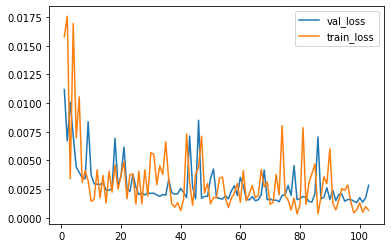

In [53]:
plt.plot(epochs, val_loss,label='val_loss')
plt.plot(epochs, train_loss,label='train_loss')
plt.legend()


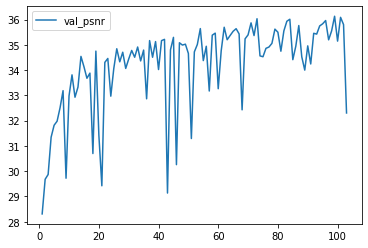

In [54]:
plt.plot(epochs, val_psnr, label='val_psnr')
plt.legend()


***Prepare dataset***

In [20]:
train_loader = DataHandler(
            lr_dir=lr_train_dir,
            hr_dir=hr_train_dir,
            patch_size=patch_size,
            scale=scaling_factor,
            transform = torchvision.transforms.Compose(
                                                        [
                                                        ToTensor(normalize = True),
                                                        RandomRotation(),
                                                        RandomHorizontalFlip(0.5),
                                                        ] 
                                                      )
        ) 


val_dataset = SRDatasetVal(lr_val_dir, hr_val_dir, scaling_factor=scaling_factor,transform = torchvision.transforms.Compose(
                                                        [
                                                        ToTensor(normalize = True),
                                                        ] 
                                                      ),n_validations_samples= n_validation_samples)






# Trainer class


In [21]:
class Trainer(object):
  def __init__(self, model = None,checkpoint = None ,best_checkpoint=None, device = None):
    self.model = model
    self.optimizer = None
    self.scheduler = None
    self.checkpoint = checkpoint
    self.best_checkpoint = best_checkpoint
    self.history = []
    self.start_epoch = 1
    self.device = device
    self.best_psnr = 0
    self.vgg = None
    self._load_checkpoint()
    self._get_default_device()


  def _get_default_device(self):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if self.device is None:
      self.device = device
    


      
  def _load_checkpoint(self):
    if self.checkpoint is not None:
      self.checkpoint = torch.load(self.checkpoint)
      if self.best_checkpoint:
        best_checkpoint = torch.load(self.best_checkpoint)
        self.best_psnr = best_checkpoint['history'][-1]['val_psnr']

      self.start_epoch = self.checkpoint['epoch'] + 1
      self.model.load_state_dict(self.checkpoint['model_state_dict'])

      self.history = self.checkpoint['history']
      

  def compile(self, optimizer, criterion , lr_scheduler, step_sched, vgg =None):
    self.model.to(self.device)
    self.criterion = criterion
    self.optimizer = optimizer(self.model.parameters(), lr = lr)
    self.scheduler = lr_scheduler(self.optimizer, step_size = step_sched, gamma = 0.5) # halved every 2e5 step
    # if self.checkpoint:
    #   self.optimizer.load_state_dict(self.checkpoint['optimizer_state_dict'])  
    #   self.scheduler.load_state_dict(self.checkpoint['scheduler_state_dict'])
    if vgg:
      self.vgg = vgg
 

  def training_step(self, input, label):
    #one batch training
    self.model.train()
    #forward pass
    srs = self.model(input)

    #train with vgg-space
    if self.vgg:
      srs = self.vgg(srs)
      label = self.vgg(label).detach()


    #loss
    loss = self.criterion(srs, label)
    loss.backward()
    
    
    #backward pass
    self.optimizer.step()
    self.optimizer.zero_grad()
    self.scheduler.step()
    return loss.item()

  @torch.no_grad()
  def validation_step(self, validation_data):
    self.model.eval()
    loss_metrics = AverageMeter()
    psnr_metrics = AverageMeter()
    self.model.eval()
    for batch in validation_data:
      lrs = batch['lr'].to(self.device)
      hrs = batch['hr'].to(self.device)
      srs_val = self.model(lrs)

      


      loss = self.criterion(srs_val, hrs)
      

      
      preds = convert_rgb_to_y(denormalize(srs_val.squeeze(0)), dim_order='chw')
      labels = convert_rgb_to_y(denormalize(hrs.squeeze(0)), dim_order='chw')
      psnr_val = cal_psnr(preds, labels)
      
      loss_metrics.update(loss.item())
      psnr_metrics.update(psnr_val)
    return loss_metrics.val , psnr_metrics.val



  def _save_state(self ,epoch,model,optmizer, scheduler,history, path):
    torch.save(
        {
            'epoch':epoch,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optmizer.state_dict(),
            'scheduler_state_dict':scheduler.state_dict(),
            'history':history,
        }
        ,path
    )

  def _save_best(self, val, epoch):
    arg = (epoch, self.model,self.optimizer,self.scheduler, self.history)
    if val > self.best_psnr:
      self.best_psnr = val
      self.best_epoch = epoch
      self._save_state(*arg,best_ckp)
    else:
      self._save_state(*arg,train_ckp))

  def on_epoch_end(self, epoch_loss, loss_val, psnr_val):
    
    self.history.append({
        'epoch':self.start_epoch,
        'loss':epoch_loss,
        
        'val_psnr':psnr_val,
        'val_loss':loss_val,
      })

    self._save_best(psnr_val, self.start_epoch)
    
    #logging
    print("Epoch [{}],  train_loss: {:.4f}, val_psnr: {:.4f}, learning_rate: {:.4f}".format(
            self.start_epoch, epoch_loss,psnr_val,  self.optimizer.param_groups[0]['lr']))
    
    self.start_epoch += 1
    

  @torch.no_grad()
  def visualize(self, img):
    self.model.eval()
    
    sr = self.model(img.to(self.device))
    img = sr.squeeze(dim = 0).cpu()
    save_image(img, 'training_process/epoch {}.png'.format(self.start_epoch))
    
 
  def fit(self, epochs, train_data, val_data, batch_size, iterations_per_epoch):
    assert ( self.criterion and self.optimizer ) , 'Call compile first'
    assert self.model , ' Invalid model instance '

    epoch_loss = AverageMeter()
    epoch_psnr = AverageMeter()

    for epoch in range(epochs):
      
      #reset metrics
      epoch_loss.reset()
      

      #batches training
      for _ in range(iterations_per_epoch):
        batch = train_data.get_batch(batch_size)
        lrs = batch['lr'].to(self.device)
        hrs = batch['hr'].to(self.device)
        loss = self.training_step(lrs, hrs)
        epoch_loss.update(loss)

      
      loss_val, psnr_val = self.validation_step(val_data)
      self.on_epoch_end(epoch_loss.val, loss_val, psnr_val)

      # self.visualize(val_data[7]['lr'] )

      
    
    

In [22]:
rdn = ResidualDenseNet( num_blocks=num_blocks, growth_rate=growth_rate, scale=scaling_factor, num_layers=num_layers, shallow_feature=num_features)

In [23]:
trainer = Trainer(rdn, train_ckp, best_ckp)
trainer.compile(optimizer=torch.optim.Adam, criterion=torch.nn.L1Loss(),lr_scheduler=torch.optim.lr_scheduler.StepLR,step_sched = 2e5, vgg=None)


In [42]:
trainer.fit(100, train_loader, val_dataset, batch_size, iterations_per_epoch)

Epoch [106],  train_loss: 0.0078, val_psnr: 36.0566, learning_rate: 0.0001
Epoch [107],  train_loss: 0.0047, val_psnr: 36.1069, learning_rate: 0.0001


KeyboardInterrupt: ignored